# Билет 2

## Задание 2

Реализовав сверточную нейронную сеть при помощи библиотеки PyTorch, решите задачу классификации текстов. Разделите набор данных на обучающее и тестовое множество.<br>Проверьте, является ли выборка сбалансированной. Отобразите графики значений функции потерь на обучающем множестве.<br>Отобразите confusion matrix и classification report, рассчитанные на основе тестового множества.<br><br>**Датасет**: /data/nlp/news.csv

In [1]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import seaborn as sns
import torch.nn as nn

In [2]:
# Установка корпусов для nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/demg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/demg/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/demg/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/demg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cpu



In [4]:
import re
import string

punctuation = set(string.punctuation)
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")
lemmatizer = lemmatizer = nltk.WordNetLemmatizer()
sub_pattern = r"[^a-zA-Z.,!?]"  # паттерн для удаления символов

# Удаление стоп-слов
def filter_stop_words(words):
    return [word for word in words if word not in stop_words]


# удаление знаков препинания
def filter_punctuation(words):
    return [re.sub(f"[{string.punctuation}]", "", word) for word in words]


# стемминг
def stemm_text(words):
    return [stemmer.stem(word) for word in words]


# лематизация
def lemm_text(words):
    return [lemmatizer.lemmatize(word) for word in words]


# Удаление коротких слов
def filter_short_words(words):
    return list(filter(lambda word: len(word) > 2, words))


def preprocess_text(text, type="stemmer"):
    text = re.sub(r"(?P<url>https?://[^\s]+)", "", text)  # remove URL adresses
    text = re.sub(r"\@(\w+)", "", text)  # remove usernames
    text = re.sub(r"\#(\w+)", "", text)  # remove hashtags
    text = re.sub(r"\$(\w+)", "", text)  # remove cashtags

    # удаление специальных символов и приведение к нижнему регистру
    text = re.sub(sub_pattern, " ", text).lower().strip()

    # токенизация
    text = nltk.word_tokenize(text)
    # удаление знаков препинания
    text = filter_punctuation(text)
    # Удаление стоп-слов
    text = filter_stop_words(text)

    if type == "stemmer":
        # стемминг
        text = stemm_text(text)
    else:
        text = lemm_text(text)

    text = filter_short_words(text)

    return text


In [5]:
data = pd.read_csv("../data/nlp/news.csv")

In [6]:
data.head()

,Class Index,Title,Description
0,2,Iowa Expecting Capital One Invitation (AP),AP - Here's some advice from the Capital One B...
1,1,106 mainland enterprises listed outside mainla...,"By the end of August 2004, a total of 106 Chin..."
2,4,Internet crackdown leads to over 100 arrests,In what is being called the largest global cra...
3,2,Williams vs Klitschko: When A Comet Crashes In...,09.12.04 - By Janne Romppainen: Unlike many pe...
4,4,Dell Gets \$700M Deal From Royal Philips,Dell Inc. said Thursday that it has won a \$70...


In [7]:
data['Title'] = data['Title'].apply(preprocess_text) # делаем предобработку интересующих нас данных

data['Class Index'] = data['Class Index'].astype('category')
data['label'] = data['Class Index'].cat.codes

n_classes = len(data['Class Index'].cat.categories)

In [8]:
data.head()

,Class Index,Title,Description,label
0,2,"[iowa, expect, capit, one, invit]",AP - Here's some advice from the Capital One B...,1
1,1,"[mainland, enterpris, list, outsid, mainland, ...","By the end of August 2004, a total of 106 Chin...",0
2,4,"[internet, crackdown, lead, arrest]",In what is being called the largest global cra...,3
3,2,"[william, klitschko, comet, crash, tower]",09.12.04 - By Janne Romppainen: Unlike many pe...,1
4,4,"[dell, get, deal, royal, philip]",Dell Inc. said Thursday that it has won a \$70...,3


In [9]:
# Разбиение на train и test выборки
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['Class Index'])

<BarContainer object of 4 artists>

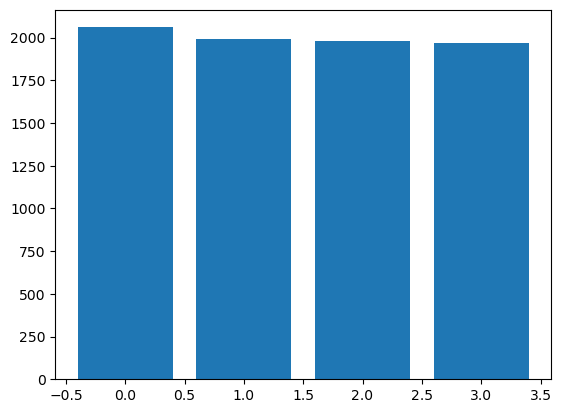

In [10]:
plt.bar(range(4), train_data['label'].value_counts()) # распределение классов по обучающей выборке

<BarContainer object of 4 artists>

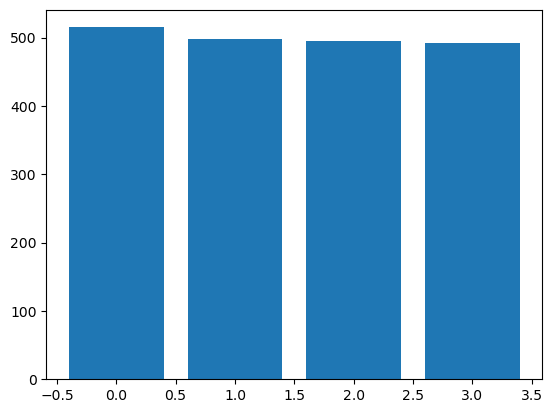

In [11]:
plt.bar(range(4), test_data['label'].value_counts()) # распределение классов по тестовой выборке

Распределения аналогичны => выборки сбалансированы

In [12]:
class Vocab:
    def __init__(self, data):
        self.idx_to_token = ["<UNK>"]
        self.token_to_idx = {"<UNK>": 0}
        self.max_words_len = 0

        self.add_words(data)

    def add_words(self, data):
        for sent in data:
            for word in sent:
                if not word in self.token_to_idx:
                    self.idx_to_token.append(word)
                    self.token_to_idx[word] = len(self.token_to_idx)

            l = len(sent)
            if l > self.max_words_len:
                self.max_words_len = l

    def __len__(self):
        return len(self.idx_to_token)


In [13]:
vocab = Vocab(train_data['Title']) # создаем словарь на основе обучающей выборки
vocab.max_words_len

12

In [14]:
class NewsDataset(Dataset):
    def __init__(self, X, y, vocab):
        self.X = X
        self.y = y
        self.vocab = vocab

    def encode(self, data):
        res = torch.zeros(vocab.max_words_len)
        for i in range(min(vocab.max_words_len, len(data))):
            res[i] = self.vocab.token_to_idx.get(data[i], 0)
        return res.to(dtype=torch.int64)

    def decode(self, vector):
        return [self.vocab.idx_to_token[idx] for idx in vector]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.encode(self.X[idx]), self.y[idx]


In [15]:
train_dataset = NewsDataset(train_data['Title'].to_numpy(), train_data['label'].to_numpy(), vocab)
test_dataset = NewsDataset(test_data['Title'].to_numpy(), test_data['label'].to_numpy(), vocab)

In [16]:
batch_size = 20

train_dataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataLoader = torch.utils.data.DataLoader(test_dataset,batch_size=500)

In [17]:
class NewsClassifier(nn.Module):
    def __init__(self, vocab, n_classes, embedding_dim = 64):
        super(NewsClassifier, self).__init__()
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embedding_dim)
        self.features = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=512, kernel_size=2),
            nn.BatchNorm1d(num_features=512),
            nn.ReLU(),
            nn.Dropout(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=512, out_channels=128, kernel_size=2),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(),
            nn.Dropout(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=128, out_channels=64, kernel_size=2),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes),
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.reshape(-1, x.size(2), x.size(1))
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [18]:
model = NewsClassifier(vocab, n_classes).to(device)
torch.manual_seed(42)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [19]:
def train_model(model, train_dataLoader, input_size, loss_f, optimizer, n_epochs, log_interval, batch_size, device='cpu'):
    model.train()
    
    losses = []

    for epoch in range(n_epochs):
        loss_total = 0
        for i,(X, y) in enumerate(train_dataLoader):
            X = X.to(device)
            y = y.to(device, dtype=torch.int64)
            
            optimizer.zero_grad()

            y_pred = model.forward(X)

            loss = loss_f(y_pred,y)
            loss.backward()
            optimizer.step()
            loss_total += loss.item()

            if (i + 1) % log_interval == 0:
                print('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                    %(epoch+1, n_epochs, i+1, len(train_dataLoader.dataset)//batch_size, loss.item()))

        losses.append(loss_total / len(train_dataLoader))

    return losses

In [20]:
losses = train_model(model, train_dataLoader, -1, loss_f, optimizer, 15, 300, batch_size, device)

Epoch : 1/15, Iter : 300/400,  Loss: 1.3556
Epoch : 2/15, Iter : 300/400,  Loss: 1.2036
Epoch : 3/15, Iter : 300/400,  Loss: 1.1745
Epoch : 4/15, Iter : 300/400,  Loss: 1.1382
Epoch : 5/15, Iter : 300/400,  Loss: 1.0041
Epoch : 6/15, Iter : 300/400,  Loss: 0.8258
Epoch : 7/15, Iter : 300/400,  Loss: 0.5395
Epoch : 8/15, Iter : 300/400,  Loss: 0.7802
Epoch : 9/15, Iter : 300/400,  Loss: 0.4005
Epoch : 10/15, Iter : 300/400,  Loss: 0.3155
Epoch : 11/15, Iter : 300/400,  Loss: 0.3882
Epoch : 12/15, Iter : 300/400,  Loss: 0.5337
Epoch : 13/15, Iter : 300/400,  Loss: 0.1746
Epoch : 14/15, Iter : 300/400,  Loss: 0.2221
Epoch : 15/15, Iter : 300/400,  Loss: 0.0764


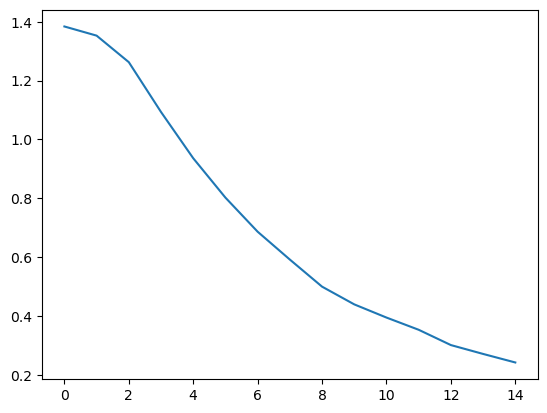

In [21]:
plt.plot(losses)

In [22]:
def show_err_matrix(class_names, y, y_pred):
    fig, ax = plt.subplots(figsize=(10, 8))
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names)
    plt.yticks(ticks, class_names)

    confusion_matrix = metrics.confusion_matrix(y, y_pred)
    sns.heatmap(pd.DataFrame(confusion_matrix), annot=True)


def validate(model, test_dataLoader, classes):
    model.eval()

    y_pred_list = []
    y_list = []

    for _, (X, y) in enumerate(test_dataLoader):
        X = X.to(device)
        y = y.to(device)

        y_pred = model.forward(X).argmax(dim=1).detach().cpu().numpy()
        y_pred_list.append(y_pred)
        y = y.detach().cpu().numpy()
        y_list.append(y)

    y_pred = np.concatenate(y_pred_list)
    y = np.concatenate(y_list)

    accuracy = metrics.accuracy_score(y, y_pred)
    print(f"Test Accuracy: {accuracy}")

    show_err_matrix(classes, y, y_pred)
    print(metrics.classification_report(y, y_pred))


Test Accuracy: 0.6965
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       515
           1       0.69      0.79      0.74       492
           2       0.63      0.65      0.64       495
           3       0.71      0.62      0.66       498

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



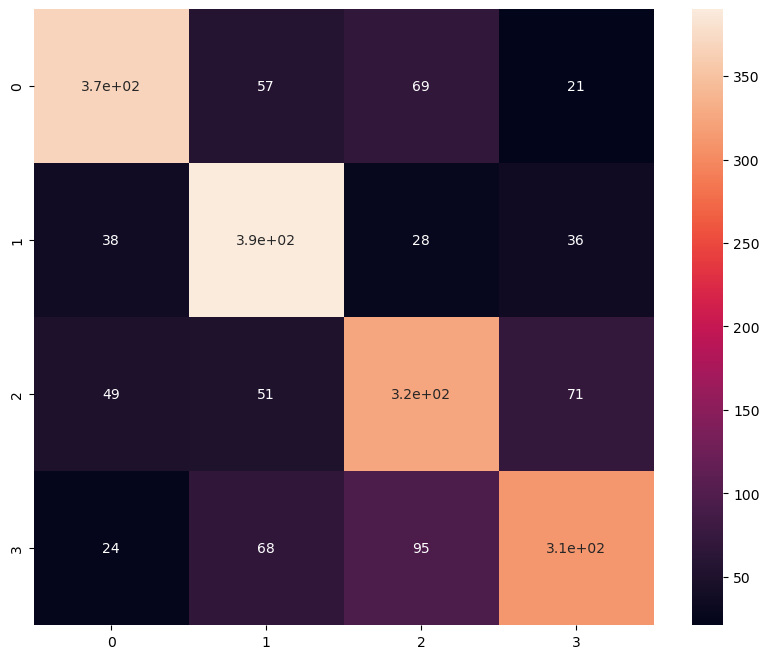

In [23]:
validate(model, test_dataLoader, data['Class Index'].cat.codes)